A soil water retention curve represents the relationship between the amount of water in the soil typically expressed on a volume basis (i.e., volumetric soil water content) and the energy-state of the soil water expressed in units of energy per unit volume ($J/m^3$), energy per unit mass ($J/kg$), or units of pressure/tension ($kPa$). This curve is fundamental for understanding soil water storage and flow in porous media in applications like irrigation management, drainage, ground water recharge, and soil water availability to plants. 

The shape of the curve is largely dictated by soil physical properties such as texture, structure, and organic matter that control the surface area and pore size distribution of the soil. Soil water retention curves are usually determined empirically by collecting soil samples and using a series of laboratory instruments to quantify the soil water content at different tension levels. In this exercise we will fit common models used in the scientific literature to a dataset determined in our soil physics lab.


In [60]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc


In [61]:
# Read dataset
df = pd.read_csv('../datasets/soil_water_retention_curve.csv')
df['theta'] = df['theta']/100
df.head()

,matric,theta
0,0.001,0.448
1,0.001,0.448
2,0.056,0.448
3,0.173,0.447
4,0.286,0.447


## Define soil water retetnion models

#### Brooks and Corey model (1964)

$$ \frac{\theta - \theta_r}{\theta_s - \theta_r} = \Bigg( \frac{\psi_e}{\psi} \Bigg)^\lambda $$

where:

$\theta$ is the volumetric water content $(cm^3/cm^3)$<br>
$\theta_r$ is the residual water content $(cm^3/cm^3)$<br>
$\theta_s$ is the saturation water content $(cm^3/cm^3)$<br>
$\psi$ is the matric potential $(kPa)$<br>
$\psi_e$ is the air-entry suction $(kPa)$<br>
$\lambda$ is a parameter related to the pore-size distribution<br>


In [77]:
def brooks_corey_model(x,alpha,lmd,psi_e,theta_r,theta_s):
    """
    Function that computes volumetric water content from soil matric potential
    using the Brooks and Corey (1964) model.
    """
    theta = np.minimum(theta_r + (theta_s-theta_r)*(psi_e/x)**(lmd), theta_s)
    return theta

#### van Genuchten model (1980)

$$ \frac{\theta - \theta_r}{\theta_s - \theta_r} = [1 + (-\alpha \psi)^n]^{-m} $$
 
where:

$\alpha$ is a fitting parameter inversely related to $\psi_e$ $(kPa^{-1})$<br>
$n$ is a fitting parameter<br>
$m$ is a fitting parameter that is often assumed to be $M=1-1/n$, but in this example it was left as a free parameter (see article by Groenevelt and Grant (2004) for mo details.<br>


In [79]:
def van_genuchten_model(x,alpha,n,m,theta_r,theta_s):
    """
    Function that computes volumetric water content from soil matric potential
    using the van Genuchten (1980) model.
    """
    theta = theta_r + (theta_s-theta_r)*(1+(alpha*x)**n)**-(1-1/n)
    return theta

#### Kosugi model (1994)

$$ \theta = \theta_r + \frac{1}{2} (\theta_s - \theta_r) \ erfc \Bigg( \frac{ln(\psi/ \psi_m)}{\sigma \sqrt(2)}  \Bigg)$$

where:

$erfc$ is the complementary error function<br>
$\sigma$ is the standard deviation of $ln(\psi_{med})$<br>
$\psi_m$ is the median matric potential



In [80]:
def kosugi_model(x,hm,sigma,theta_r,theta_s):
    """
    Function that computes volumetric water content from soil matric potential
    using the Kosugi (1994) model. Function was implemented accoridng 
    to Eq. 3 in Pollacco et al., 2017.
    """
    theta = theta_r + 1/2*(theta_s-theta_r)*erfc(np.log(x/hm)/(sigma*np.sqrt(2))) 
    return theta

#### Groenvelt-Grant model (2004)
$$ \theta = k_1 \Bigg[ exp\Bigg( \frac{-k_0}{\big(10^{5.89}\big)^n} \Bigg) - exp\Bigg( \frac{-k_0}{\psi ^n} \Bigg) \Bigg]$$

where:

$k_0$, $k_1$, and $n$ are fitting parameters. The value $10^{5.89}$ is the matric potential in $kPa$ at oven-dry conditions (105 degrees Celsius)

In [82]:
def groenevelt_grant_model(x,k0,k1,n,theta_s):
    """
    Function that computes volumetric water content from soil matric potential 
    using the Groenevelt-Grant (2004) model.
    """
    theta = k1 * ( np.exp(-k0/ (10**5.89)**n) - np.exp(-k0/(x**n)) ) # Eq. 5 in Groenevelt and Grant, 2004
    return theta


## Define error models

In [83]:
# Error models
mae_fn = lambda x,y: np.round(np.mean(np.abs(x-y)),3)
rmse_fn = lambda x,y: np.round(np.sqrt(np.mean((x-y)**2)),3)


In [87]:
1-1/1.5

0.33333333333333337

## Fit soil water retention models to dataset

In [94]:
# Define variables
x_obs = df["matric"]
y_obs = df["theta"]
x_curve = np.logspace(-1.5,5,1000)

# Empty list to collect output of each model
output = []

# van Genuchten model
p0 = [0.02,1.5,1,0.1,0.5]
bounds = ([0.001,1,0,0,0.3], [1,10,25,0.3,0.6])
par_opt, par_cov = curve_fit(van_genuchten_model, x_obs, y_obs, p0=p0, bounds=bounds)
y_curve = van_genuchten_model(x_curve, *par_opt)
output.append({'name':'van Genuchten',
               'y_curve':y_curve,
               'mae':mae_fn(van_genuchten_model(x_obs, *par_opt), y_obs),
               'rmse':rmse_fn(van_genuchten_model(x_obs, *par_opt), y_obs),
               'par_values':par_opt,
               'par_names':van_genuchten_model.__code__.co_varnames,
               'color':'black'})
    
# Brooks and Corey
p0=[0.02, 1, 10, 0.1, 0.5]
bounds=([0.001, 0.1, 1, 0, 0.3], [1, 10, 100, 0.3, 0.6])
par_opt, par_cov = curve_fit(brooks_corey_model, x_obs, y_obs, p0=p0, bounds=bounds)
y_curve = brooks_corey_model(x_curve, *par_opt)
output.append({'name':'Brooks and Corey',
               'y_curve':y_curve,
               'mae':mae_fn(brooks_corey_model(x_obs, *par_opt), y_obs),
               'rmse':rmse_fn(brooks_corey_model(x_obs, *par_opt), y_obs),
               'par_values':par_opt,
               'par_names':brooks_corey_model.__code__.co_varnames,
               'color':'tomato'})


# Kosugi
p0=[50, 1, 0.1, 0.5]
bounds=([1, 1, 0, 0.3], [500, 10, 0.3, 0.6])
par_opt, par_cov = curve_fit(kosugi_model, x_obs, y_obs, p0=p0, bounds=bounds)
y_curve = kosugi_model(x_curve, *par_opt)
output.append({'name':'Kosugi',
               'y_curve':y_curve,
               'mae':mae_fn(kosugi_model(x_obs, *par_opt), y_obs),
               'rmse':rmse_fn(kosugi_model(x_obs, *par_opt), y_obs),
               'par_values':par_opt,
               'par_names':kosugi_model.__code__.co_varnames,
               'color':'darkgreen'})


# Groenevelt-Grant
p0=[5, 1, 2, 0.5]
bounds=([1, 0.1, 0.1, 0.3], [2000, 10, 5, 0.6])
par_opt, par_cov = curve_fit(groenevelt_grant_model, x_obs, y_obs, p0=p0, bounds=bounds)
y_curve = groenevelt_grant_model(x_curve, *par_opt)
output.append({'name':'Groenevelt-Grant',
               'y_curve':y_curve,
               'mae':mae_fn(groenevelt_grant_model(x_obs, *par_opt), y_obs),
               'rmse':rmse_fn(groenevelt_grant_model(x_obs, *par_opt), y_obs),
               'par_values':par_opt,
               'par_names':groenevelt_grant_model.__code__.co_varnames,
               'color':'lightblue'})


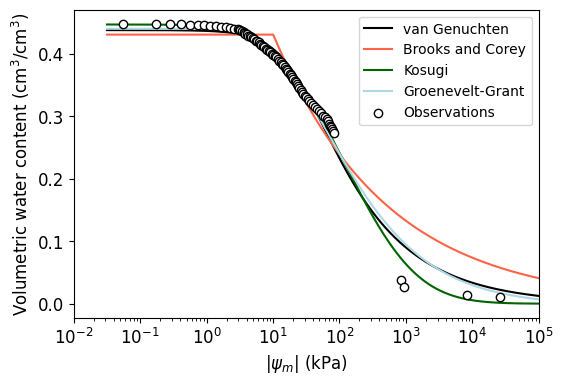

In [95]:
# Create figure
# Plot results
plt.figure(figsize=(6,4))
for model in output:
    plt.plot(x_curve, model['y_curve'], color=model['color'],
             linewidth=1.5, label=model['name'])
plt.scatter(x_obs, y_obs, marker='o', facecolor='w', 
            alpha=1, edgecolor='k', zorder=10, label='Observations')
plt.xscale('log')
plt.xlabel('$|\psi_m|$ (kPa)', size=12)
plt.ylabel('Volumetric water content (cm$^3$/cm$^3$)', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0.01, 100_000])
plt.legend()
plt.show()


In [96]:
# Print parameters
for k,model in enumerate(output):
    print(model['name'])
    for par_name, par_value in list(zip(model['par_names'][1:], model['par_values'])):
        print(par_name, '=', par_value)
    print('')

van Genuchten
alpha = 0.03982164458016106
n = 1.4290698142534732
m = 15.450501882131682
theta_r = 3.797456144597235e-21
theta_s = 0.4376343934467054

Brooks and Corey
alpha = 0.02
lmd = 0.25592618085795293
psi_e = 10.068459416938797
theta_r = 2.402575753992586e-21
theta_s = 0.430430826679669

Kosugi
hm = 122.18916515441454
sigma = 1.962113379238266
theta_r = 4.989241799635874e-22
theta_s = 0.44660152453875435

Groenevelt-Grant
k0 = 8.104570970997068
k1 = 0.44363145088075745
n = 0.502979559118283
theta_s = 0.5



## References

Brooks, R. H. (1965). Hydraulic properties of porous media. Colorado State University.

Groenevelt, P.H. and Grant, C.D., 2004. A new model for the soil‐water retention curve that solves the problem of residual water contents. European Journal of Soil Science, 55(3), pp.479-485.

Kosugi, K. I. (1994). Three‐parameter lognormal distribution model for soil water retention. Water Resources Research, 30(4), 891-901.

Pollacco, J. A. P., Webb, T., McNeill, S., Hu, W., Carrick, S., Hewitt, A., & Lilburne, L. (2017). Saturated hydraulic conductivity model computed from bimodal water retention curves for a range of New Zealand soils. Hydrology and Earth System Sciences, 21(6), 2725-2737.

van Genuchten, M.T., 1980. A closed form equation for predicting hydraulic conductivity of unsaturated soils: Journal of the Soil Science Society of America.